In [4]:
# needed libraries
from numpy.core.fromnumeric import mean
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, Conv1D, LSTM, GRU, Bidirectional, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

## Define constants
In the following cell we are defining the constants for the dataset csv and the paths where the best weights for each model will be saved. The function creates a model_checkpoint to store the best weights.

In [5]:
# Constants
TAG_RE = re.compile(r'<[^>]+>')
DATA_PATH = "IMDB Dataset.csv"
MAX_LEN = 100
checkpoint_filepath_lstm = 'checkpoint/weights_lstm'
checkpoint_filepath_cnn = 'checkpoint/weights_cnn'
checkpoint_filepath_bi_lstm = 'checkpoint/weights_bi_lstm'
checkpoint_filepath_gru = 'checkpoint/weights_gru'
checkpoint_filepath_best_lstm = 'checkpoint/weights_best_lstm'
checkpoint_filepath_simple_nn = 'checkpoint/weights_simple_nn'

def create_checkpoint(path):
    model_checkpoint = ModelCheckpoint(
        filepath = path,
        save_weights_only = True,
        monitor = 'val_acc',
        mode = 'max',
        save_best_only = True
    )
    
    return model_checkpoint

## Analyzing the dataset
The file contains 50,000 records and two columns: review and sentiment. The review column contains text for the review and the sentiment column contains sentiment for the review. The sentiment column can have two values:
- Positive
- Negative

It is a binary classification problem and a supervised problem because the class classification is known beforehand.

In [6]:
def read_data(path):
    # Kaggle dataset of 50K Moview Reviews
    movie_reviews = pd.read_csv(path)
    movie_reviews.isnull().values.any()
    
    return movie_reviews

## Preprocessing data:
The reviews contain punctuations, brackets and some HTML tags and all of them must be reviewed for a good training. The function that preprocesses the data takes as input parameter a review in form of string and removes special characters and HTM tags.

In [7]:
def remove_tags(text):

    return TAG_RE.sub('', text)

In [8]:
def preprocess_text(review):
    review = remove_tags(review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = re.sub(r"\s+[a-zA-Z]\s+", ' ', review)
    review = re.sub(r'\s+', ' ', review)

    return review

## Split data into train and test:
The following function takes as input argument the panda data frame that is the csv file, this data frame has two columns:
1. For the first column, each review is preprocessed and stored in a list.
2. For the second column, the class is binarized and stored in a list.

Finally, we have the X array that is the input data with what the model will train and the array y that is classification class binarized.

We will split the data into train and test subsets using the scikit learn train_test_split function, with a test size of 20%. 

In [9]:
def create_train_test(movie_reviews):
    X = []
    reviews = list(movie_reviews['review'])
    for review in reviews:
        X.append(preprocess_text(review))
    y = movie_reviews['sentiment']
    y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    return X_train, X_test, y_train, y_test

## Embedding Layer
First step is to create the tokenizer model to create a word-to-index dictionary where each word is used as a key and a unique index is used as the value for the key.

Second step is to use the GloVe embeddings file to create the feature matrix:
- File accessible from Kaggle: https://www.kaggle.com/danielwillgeorge/glove6b100dtxt

By loading the GloVe embeddings file we will create a dictinary with words as keys and their corresponding embedding list as values.

Finally, we will create an embedding matrix where each row number will correspond to the index of the word in the corpus. The matrix will have 100 columns where each column will contain the GloVe word embeddings for the words in our corpus. The number of columns can be changed depending on what we want but for this purpose it is correct to set it to 100, if one row has less than 100 columns the missing ones will be filled with zeros.

Embedding_matrix = 92547x100, so the corpus is formed by 92547 words. The embedding matrix will be the input weigts for training the models so it is very important to build it correctly

**Note:** The GloVe file must be placed in the same directory in which it is this notebook for the functions to work, and it is necessary to download it.

In [10]:
def prepare_embedding_layer(X_train, X_test):
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    vocab_size = len(tokenizer.word_index) + 1 # unique words of the corpus
    X_train = pad_sequences(X_train, padding='post', maxlen=MAX_LEN)
    X_test = pad_sequences(X_test, padding='post', maxlen=MAX_LEN)

    embeddings_dictionary = dict()
    glove_file = open('glove.6B.100d.txt', encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()

    embedding_matrix = np.zeros((vocab_size, 100))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    return X_train, X_test, embedding_matrix, vocab_size, tokenizer

## Printing graphs
This function takes as input parameter the history of the trained model and prints two different graphs:
1. Accuracy: comparison between the accuracy in validation and test
2. Loss: comparison between the loss in validation and test

In [11]:
def print_graphs(out_values):
    plt.plot(out_values.history['acc'])
    plt.plot(out_values.history['val_acc'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()

    plt.plot(out_values.history['loss'])
    plt.plot(out_values.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()

Also here we provide 2 functions. The first one to plot the ROC curve for a given TPR (True Positive Rate) and FNR (False Negative Rate). The second one plots a confusion matrix provided by the user.

In [12]:
def print_ROC_curve(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Performance Metrics

This function takes as input the predictions and the real outputs and calculates returns some metric values to measure the performace of the model. This metrics are: TPD, FRP and AUC to calculate the ROC curve; as well as the confusion matrix.

In [14]:
def get_performance_metrics(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    print (fpr, tpr)
    roc_auc = auc(fpr, tpr)
    c = confusion_matrix(y_true, y_pred)
    
    return fpr, tpr, roc_auc, c

## Make Predictions

We also privide a function that, given a model and a concrete review, predicts if that review is a positive or negative review

In [15]:
def make_prediction(model, path, rvw):
    model.load_weights(path)
    rvw = tokenizer.texts_to_sequences(rvw)
    #padding the review to have exactly the same shape as `embedding_2` input
    rvw = pad_sequences(rvw, maxlen=MAX_LEN, dtype='int32', value=0)
    sentiment = model.predict(rvw,batch_size=1,verbose = 2)[0]
    print(sentiment)
    if sentiment <= 0.5:
        print("The review is negative")
    else:
        print("The review is positive")

## First Step: Generate the dataset

Once all the reqired functions are impelemnted and before start to analize some models, we are going to obtain the data. To do so:

1. We read the dataset.
2. Create the train and test datasets.
3. Generate the embeddings of the examples.

In [16]:
# Read data and split into train and test
movie_reviews = read_data(DATA_PATH)
X_train, X_test, y_train, y_test = create_train_test(movie_reviews)
X_train, X_test, embedding_matrix, vocab_size, tokenizer= prepare_embedding_layer(X_train, X_test) # The reviews are processed as numeric lists of size 100 following a corpus
print("Data loaded!")

Data loaded!


Now we ar going to analyze different models. More exactly:

* A simple Depp Neural Network (DNN).
* Convolutional Neural Network (CNN).
* Long Short-Term Memory (LSTM).
* Bilateral LSTM.
* Gated Recurrent Unit (GRU).
* Finally, we try to improve the previous LSTM introducing some changes.

## 1. Simple Deep Neural Network (DNN)

As a first approach to the problem, we decided to implement a simple Deep Neural Network (DNN). So, first we provide the functions that are needed to creare and train the model:

In [1]:
def create_simple_nn(vocab_size, embedding_matrix):
    # define the keras model
    model = Sequential()
    model.add(Dense(vocab_size, input_dim=100, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [ ]:
def train_simple_nn(X_train, y_train, X_test, y_test, model):
    model_checkpoint_callback_simple_nn = create_checkpoint(checkpoint_filepath_simple_nn)
    out_values = model.fit(X_train, y_train, batch_size=128, epochs=6,
                           callbacks=[model_checkpoint_callback_simple_nn],
                           verbose=1, validation_split=0.2)

    score_test = model.evaluate(X_test, y_test, verbose=1)
    print("Test Score for the simple nn model:", score_test[0])
    print("Test Accuracy for the simple nn model:", score_test[1])
    print_graphs(out_values)
    
    return model

### Training the DNN (can be skipped)

Next, we train the model. This step can be skipped, as we provide the weights obtained in the training step and it is only needed to load them. But you can re-train the model if you want.

In [ ]:
model = create_simple_nn(vocab_size, embedding_matrix)
print(model.summary())
model = train_simple_nn(X_train, y_train, X_test, y_test, model)

### Plot the ROC curve and Confusion Matrix

In [ ]:
# Compute ROC curve for the simple NN model
model = create_simple_nn(vocab_size, embedding_matrix)
model.load_weights(checkpoint_filepath_simple_nn)
predictions = model.predict(X_test)
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

fpr, tpr, roc_auc, c = get_performance_metrics(y_test.reshape(-1, 1), predictions.astype('int'))
print_ROC_curve(fpr, tpr, roc_auc)

plot_confusion_matrix(c, normalize=True, target_names=['Negative Review', 'Positive Review'])

In [ ]:
# Particular prediction with the DNN model
model = create_simple_nn(vocab_size, embedding_matrix)
rvw = ['I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned']
make_prediction(model, checkpoint_filepath_simple_nn, rvw)

### Conclusion

As shown in the graphs, the performance of the NN is quite bad. So now, he have a first approach, we are going to introduce more specialised models.

## 2. Convolutional Neural Network (CNN)

These days Convolutional Neural Networks (CNN) are widely used for computer vision tasks. But also, they can provide a good performance in other tasks. They are une of the most known NN architectures and the great evolution in the field of Deep Learning seen this las years is in part thanks to CNNs. That's why we decided to implement a CNN to try to solve this problem.

In [17]:
def create_model_cnn(vocab_size, embedding_matrix):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=MAX_LEN , trainable=False)
    model.add(embedding_layer)
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    return model

In [18]:
def train_cnn(X_train, y_train, X_test, y_test, model):
    model_checkpoint_callback_cnn = create_checkpoint(checkpoint_filepath_cnn)
    # In each epoch the actual hyperparameters will be tested with the validation set
    out_values = model.fit(X_train, y_train, batch_size=128, epochs=6,
                           callbacks=[model_checkpoint_callback_cnn],
                           verbose=1,
                           validation_split=0.2)
    score_test = model.evaluate(X_test, y_test, verbose=1)
    print("Test Score for the Convolutional Neural Network:", score_test[0])
    print("Test Accuracy for the Convolutional Neural Network:", score_test[1])
    print_graphs(out_values)

    return model

### Training the CNN (can be skipped)¶

As in the case of the DNN, it is not necesary to train the CNN, but we provide here the possibility to do it.

In [ ]:
# Train cnn and print graphs
model = create_model_cnn(vocab_size, embedding_matrix)
print(model.summary())
model = train_cnn(X_train, y_train, X_test, y_test, model)
# Save the model 
model.save("")

### Plot the ROC curve and Confusion Matrix

[0.         0.14069744 1.        ] [0.         0.84322286 1.        ]


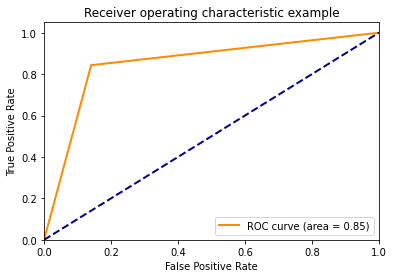

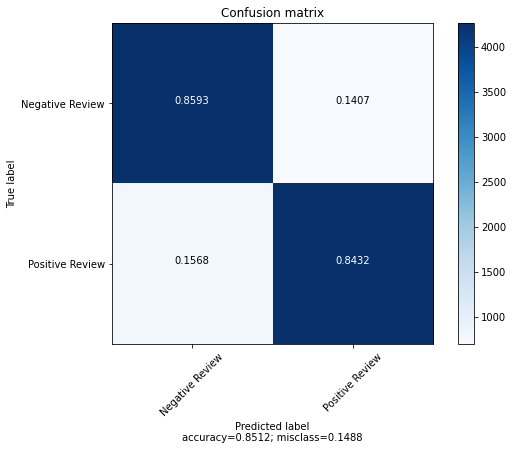

In [19]:
# Compute ROC curve for the CNN model
model = create_model_cnn(vocab_size, embedding_matrix)
model.load_weights(checkpoint_filepath_cnn)
predictions = model.predict(X_test)
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

fpr, tpr, roc_auc, c = get_performance_metrics(y_test.reshape(-1, 1), predictions.astype('int'))
print_ROC_curve(fpr, tpr, roc_auc)

plot_confusion_matrix(c, normalize=True, target_names=['Negative Review', 'Positive Review'])

In [20]:
# Particular prediction with the CNN model
model = create_model_cnn(vocab_size, embedding_matrix)
rvw = ['I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned']
make_prediction(model, checkpoint_filepath_cnn, rvw)

1/1 - 0s
[0.10267559]
The review is negative


### Conclusion

Comparing to the previous model, this CNN seems to have quite a good performace. Is true that when we want to have a True Positive Rate, also we find that there is about 15% of False Positives. But we think it is a good result in this case, obiously the model can be enhanced and probably reviewing some of the SOTA models  we can obtain a better performance. 

## 3. Long Short-Term Memory (LSTM)

The LSTM based models are widely used for NLP tasks. In this case, we provide here a model using an LSTM layer.

In [21]:
def create_model_lstm(vocab_size, embedding_matrix):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=MAX_LEN , trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    return model

In [22]:
def train_lstm(X_train, y_train, X_test, y_test, model):
    model_checkpoint_callback_lstm = create_checkpoint(checkpoint_filepath_lstm)
    out_values = model.fit(X_train, y_train, batch_size=128, epochs=6,
                           callbacks=[model_checkpoint_callback_lstm],
                           verbose=1, validation_split=0.2)

    score_test = model.evaluate(X_test, y_test, verbose=1)
    print("Test Score in the Recurrent Neural Network:", score_test[0])
    print("Test Accuracy in the Recurrent Neural Network:", score_test[1])
    print_graphs(out_values)

    return model

### Training the LSTM (can be skipped)¶

In [ ]:
# Train lstm model and print graphs
model = create_model_lstm(vocab_size, embedding_matrix)
print(model.summary())
model = train_lstm(X_train, y_train, X_test, y_test, model)

### Plot the ROC curve and Confusion Matrix

[0.        0.3059867 1.       ] [0.         0.90712443 1.        ]


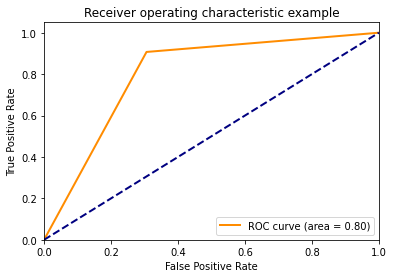

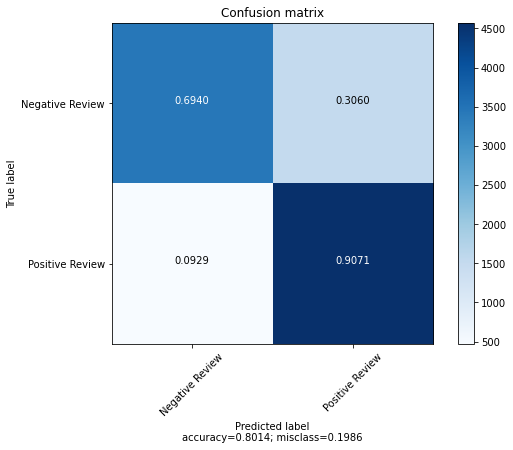

In [23]:
# Compute ROC curve for the LSTM model
model = create_model_lstm(vocab_size, embedding_matrix)
model.load_weights(checkpoint_filepath_lstm)
predictions = model.predict(X_test)
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

fpr, tpr, roc_auc, c = get_performance_metrics(y_test.reshape(-1, 1), predictions.astype('int'))
print_ROC_curve(fpr, tpr, roc_auc)

plot_confusion_matrix(c, normalize=True, target_names=['Negative Review', 'Positive Review'])

In [ ]:
# Particular prediction with the LSTM model
model = create_model_lstm(vocab_size, embedding_matrix)
rvw = ['I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned']
make_prediction(model, checkpoint_filepath_lstm, rvw)

### Conclusion

The proposed model doesn't perform fine. In fact, it can be seen that the previous CNN is much better, as it obtains better results. In this case, when we want the model to acheive a reasonable performance (that means abot 80% of True Positives), there are many misclassified instances (about the 30%).

## 4. Bilateral LSTM

As the previous LSTM based model achives such bad results, we decided to implement another LSTM based model using Bilateral (or bidirectional) LSTM layers.

In [24]:
# Improved lstm model: We are going to try Bidirectional LSTM and 
def create_bilateral_lstm(vocab_size, embedding_matrix):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=MAX_LEN , trainable=False)
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(units = 64,                             
              return_sequences=True),
              input_shape=(X_train.shape[0], X_train.shape[1])))
    model.add(Bidirectional(LSTM(64)))
    model.add((Dense(1)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [25]:
def train_bilateral_lstm(X_train, y_train, X_test, y_test, model):
    model_checkpoint_callback_bilstm = create_checkpoint(checkpoint_filepath_bi_lstm)
    out_values = model.fit(X_train, y_train, batch_size=128, epochs=6,
                           callbacks=[model_checkpoint_callback_bilstm],
                           verbose=1, validation_split=0.2)

    score_test = model.evaluate(X_test, y_test, verbose=1)
    print("Test Score for the Bilateral LSTM model:", score_test[0])
    print("Test Accuracy for the Bilateral LSTM model:", score_test[1])
    print_graphs(out_values)
    
    return model

### Training the Bilateral LSTM (can be skipped)¶


In [ ]:
# Train Bilateral model
model = create_bilateral_lstm(vocab_size, embedding_matrix)
print(model.summary())
model = train_bilateral_lstm(X_train, y_train, X_test, y_test, model)

### Plot the ROC curve and Confusion Matrix

[0.         0.37774642 1.        ] [0.         0.84877952 1.        ]


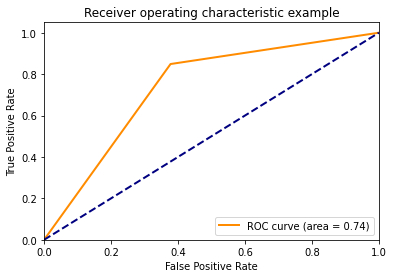

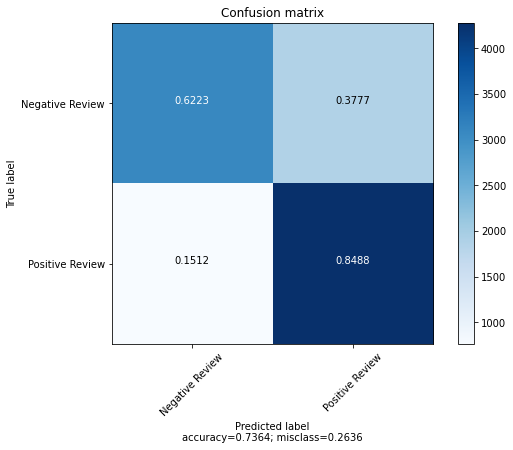

In [26]:
# Compute ROC curve for the Bilateral LSTM model
model = create_bilateral_lstm(vocab_size, embedding_matrix)
model.load_weights(checkpoint_filepath_bi_lstm)
predictions = model.predict(X_test)
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

fpr, tpr, roc_auc, c = get_performance_metrics(y_test.reshape(-1, 1), predictions.astype('int'))
print_ROC_curve(fpr, tpr, roc_auc)

plot_confusion_matrix(c, normalize=True, target_names=['Negative Review', 'Positive Review'])

In [27]:
# Particular prediction with the Bilateral LSTM model
model = create_bilateral_lstm(vocab_size, embedding_matrix)
rvw = ['I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned']
make_prediction(model, checkpoint_filepath_bi_lstm, rvw)

1/1 - 0s
[0.3808855]
The review is negative


### Conclusions

As can be seen, in this case, first the accuracy deacreases compared to the previous LSTM model; and second, to acheive the same rate of well classified instances (80%) here about the 40% of intances will be misclassified, while before we have 30% of the cases. We conclude that this imporvement or new variant does not enhance the previous ones.

## 5. Gated Recurrent Unit (GRU)

This kind of layers are similar to the LSTM ones. We implement a model where a GRU layer is used in order to see how it works comparing to the previous LSTM layer based one.

In [30]:
def create_gru(vocab_size, embedding_matrix):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=MAX_LEN , trainable=False)
    model.add(embedding_layer)
    model.add(GRU (units = 64, return_sequences = True,
                input_shape = [X_train.shape[0], X_train.shape[0]]))
    model.add(Dropout(0.2))
    model.add(GRU (units = 64))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [31]:
def train_gru(X_train, y_train, X_test, y_test, model):
    model_checkpoint_callback_gru = create_checkpoint(checkpoint_filepath_gru)
    out_values = model.fit(X_train, y_train, batch_size=128, epochs=6,
                           callbacks=[model_checkpoint_callback_gru],
                           verbose=1, validation_split=0.2)

    score_test = model.evaluate(X_test, y_test, verbose=1)
    print("Test Score for the GRU model:", score_test[0])
    print("Test Accuracy for the GRU model:", score_test[1])
    print_graphs(out_values)
    
    return model

### Training the GRU model (can be skipped)¶

In [ ]:
# Train Gru model
model = create_gru(vocab_size, embedding_matrix)
print(model.summary())
model = train_gru(X_train, y_train, X_test, y_test, model)

### Plot the ROC curve and Confusion Matrix

In [32]:
# Compute ROC curve for the Gru model
model = create_gru(vocab_size, embedding_matrix)
model.load_weights(checkpoint_filepath_gru)
predictions = model.predict(X_test)
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

fpr, tpr, roc_auc, c = get_performance_metrics(y_test.reshape(-1, 1), predictions.astype('int'))
print_ROC_curve(fpr, tpr, roc_auc)

plot_confusion_matrix(c, normalize=True, target_names=['Negative Review', 'Positive Review'])

ValueError: GRU(reset_after=False) is not compatible with GRU(reset_after=True)

In [ ]:
# Particular prediction with the GRU model
model = create_gru(vocab_size, embedding_matrix)
rvw = ['I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned']
make_prediction(model, checkpoint_filepath_gru, rvw)

### Conclusion

(NO HE PODIDO VER LAS GRAFICAS ASI QUE NI IDEA, SI PUEDES PONER ALGO)

## 6. Improved LSTM

Finally, we are goin to try to improve the first LSTM based model shown before by adding a SpatialDropout1D layer and other Dropout and Dense layers.

In [33]:
# We are going to try to improve the LSTM model by adding a SpatialDropout1D layer and 
# other Dropout and Dense layers
def create_impr_lstm(vocab_size, embedding_matrix):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=MAX_LEN , trainable=False)
    model.add(embedding_layer)
    model.add(SpatialDropout1D(0.25))
    model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [34]:
def train_impr_lstm(X_train, y_train, X_test, y_test, model):
    model_checkpoint_callback_best_lstm = create_checkpoint(checkpoint_filepath_best_lstm)
    out_values = model.fit(X_train, y_train, batch_size=128, epochs=6,
                           callbacks=[model_checkpoint_callback_best_lstm],
                           verbose=1, validation_split=0.2)

    score_test = model.evaluate(X_test, y_test, verbose=1)
    print("Test Score for the best LSTM model:", score_test[0])
    print("Test Accuracy for the best LSTM model:", score_test[1])
    print_graphs(out_values)
    
    return model

### Training the new LSTM (can be skipped)¶


In [ ]:
# Train the trying to improve the LSTM model
model = create_impr_lstm(vocab_size, embedding_matrix)
print(model.summary())
model = train_impr_lstm(X_train, y_train, X_test, y_test, model)

### Plot the ROC curve and Confusion Matrix

[0.         0.24591816 1.        ] [0.         0.83429252 1.        ]


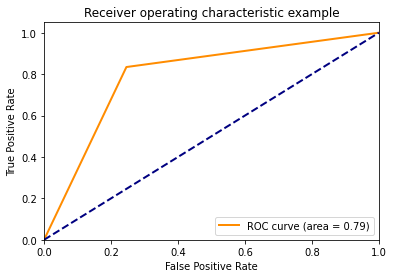

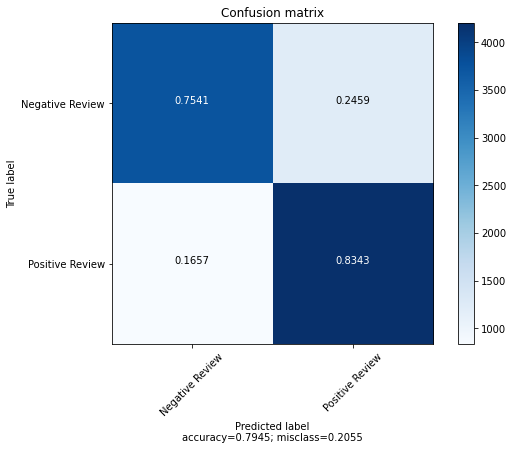

In [35]:
# Compute ROC curve for the improved LSTM model
model = create_impr_lstm(vocab_size, embedding_matrix)
model.load_weights(checkpoint_filepath_best_lstm)
predictions = model.predict(X_test)
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

fpr, tpr, roc_auc, c = get_performance_metrics(y_test.reshape(-1, 1), predictions.astype('int'))
print_ROC_curve(fpr, tpr, roc_auc)

plot_confusion_matrix(c, normalize=True, target_names=['Negative Review', 'Positive Review'])

In [36]:
# Particular prediction with the improved model
model = create_impr_lstm(vocab_size, embedding_matrix)
rvw = ['I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned']
make_prediction(model, checkpoint_filepath_best_lstm, rvw)

1/1 - 0s
[0.31720385]
The review is negative


### Conclusion

We can see that in this case, the accuracy (79.45%) is similar to the first LSTM model (80.14%). Also, refering to the computed ROC curves in both cases, we see that this proposal enhance the previous one, as the FPR decays until the 20% when we have a TPR of the 80%

## General Conclusions

In this work we have done a hands on work in NLP to solve a task of sentyment analysis. We decided to usea Neural Networks as these days the field of Deel Learning is being widely used, even if for obtaining good results, the amount of data that we have was not the best one, we need more intances so the deep learning models could perform better. In relation with this, maybe other kind of models such as Vector Space Models (VSM) can obtain better results, but, as mentioned, we wanted to do this hands-on work from a more actual point of view.

First, we implemented a simple Deep Neural Network, in order to make a first approach. Obiously, this model dindn't obtain any good result. Then, we implement a CNN. This kind of model are very used these days (specially in computer vision tasks), and this model was the one who obtain the best resuts.

After that, we introduce a model using LSTM. Unfortunately, the results obtained were not very good. We tied to improve this implementation using Bilateral LSTM and GRU layers. In this case, the performace compared with the original LSTM decreases, so it is was not a good solution.

Finaly, we porpose a change to the original LSTM by adding a SpatialDropout1D layer and other Dropout and Dense layers. This new change was similar to the originial one, but it enhance it a little bit. This was shown comparing both ROC curves.